In [10]:
import torch
import timm
import requests
#pip install timm
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from io import BytesIO

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = timm.create_model('vit_base_patch14_dinov2', pretrained=True)
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identit

In [12]:
def load_image(img_path, max_size=512, shape=(518,518)):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    in_transform = transforms.Compose([
                        transforms.Resize(shape),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image.to(device)


In [13]:
def extract_dinov2_features(image_path, model):
    image_input = load_image(image_path)
    with torch.no_grad():
        features = model(image_input) 

    return features.squeeze().cpu().numpy()

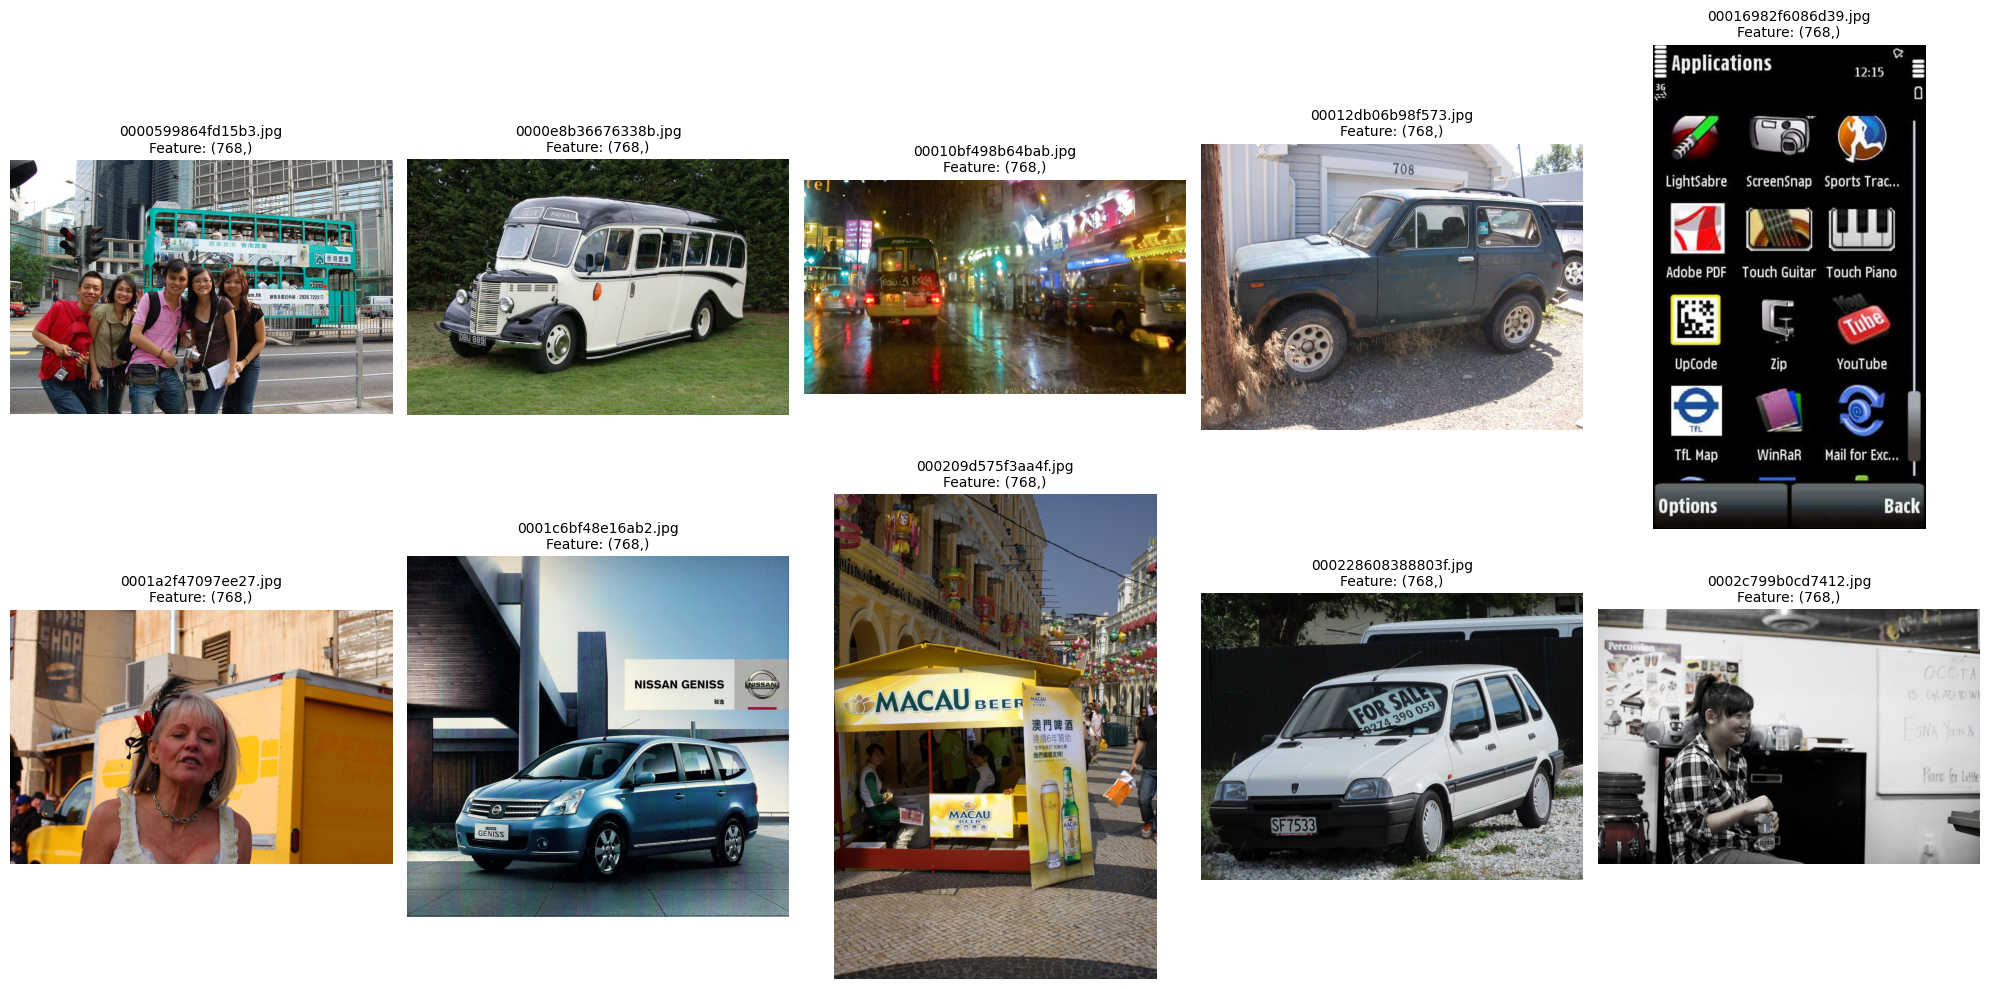

In [ ]:
image_dir = "/research2/lrbutler/TextBasedImageSearch/data/raw_data/train_images/"
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(".jpg")])[:10]
plt.figure(figsize=(20, 10))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)

    image = Image.open(image_path).convert("RGB")

    features = extract_dinov2_features(image_path, model)

    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{image_file}\nFeature: {features.shape}", fontsize=10)

plt.tight_layout()
plt.show()